# Figure 4 - bar chart of SWMT in control, up, down, no_katabatics

In [10]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import cartopy.crs as ccrs
import matplotlib.colors as col
import matplotlib.path as mpath
import xarray as xr
import cmocean.cm as cmocean
import glob

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client

figdir = '/g/data/v45/akm157/figures/easterlies/paper_figures/'

In [11]:
#client = Client(n_workers=4)
# >> dask-scheduler
# >> dask-worker tcp://10.0.64.9:8786 --memory-limit 4e9 --nprocs 6 --nthreads 1 --local-directory /local/g40/amh157
#client = Client('tcp://10.0.64.9:8786', local_dir='/local/g40/amh157')
client = Client()
client

Client Scheduler: tcp://127.0.0.1:37371 Dashboard: /proxy/34253/status,Cluster Workers: 8 Cores: 48 Memory: 188.57 GiB


In [12]:
master_session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')
control = '01deg_jra55v13_ryf9091'

# 3 year average: ?

start_time='2155-01-01'
# extend to 2156 once data is transferred:
end_time='2159-12-31'

lat_slice  = slice(-80,-50)
lon_slice  = slice(-280, 80)

In [13]:
# main easterlies experiments
session_name = '/g/data/v45/akm157/model_data/access-om2/01deg_jra55v13_ryf9091_easterlies_up10/easterlies.db'
easterlies_session = cc.database.create_session(session_name)

easterlies_up = '01deg_jra55v13_ryf9091_easterlies_up10'
easterlies_down = '01deg_jra55v13_ryf9091_easterlies_down10'
easterlies_up_noDSW = '01deg_jra55v13_ryf9091_easterlies_up10_noDSW'

In [14]:
# add new data to database:
session_name = '/g/data/v45/akm157/model_data/access-om2/01deg_jra55v13_ryf9091_easterlies_up10/easterlies.db'
easterlies_session = cc.database.create_session(session_name)

dir_list = ['/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091_easterlies_up10/',
           '/g/data/ik11/outputs/access-om2-01//01deg_jra55v13_ryf9091_easterlies_down10/',
           '/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091_easterlies_up10_noDSW/',
           '/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091_easterlies_up10_zonal/',
           '/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091_easterlies_up10_meridional/']
cc.database.build_index(dir_list,easterlies_session)

easterlies_up = '01deg_jra55v13_ryf9091_easterlies_up10'
easterlies_up_zonal = '01deg_jra55v13_ryf9091_easterlies_up10_zonal'
easterlies_up_meridional = '01deg_jra55v13_ryf9091_easterlies_up10_meridional'
easterlies_up_noDSW = '01deg_jra55v13_ryf9091_easterlies_up10_noDSW'
easterlies_down = '01deg_jra55v13_ryf9091_easterlies_down10'

Indexing experiment: 01deg_jra55v13_ryf9091_easterlies_up10


0it [00:00, ?it/s]


Indexing experiment: 01deg_jra55v13_ryf9091_easterlies_down10


0it [00:00, ?it/s]


Indexing experiment: 01deg_jra55v13_ryf9091_easterlies_up10_noDSW


0it [00:00, ?it/s]


Indexing experiment: 01deg_jra55v13_ryf9091_easterlies_up10_zonal


0it [00:00, ?it/s]


Indexing experiment: 01deg_jra55v13_ryf9091_easterlies_up10_meridional


0it [00:00, ?it/s]


In [15]:
# topography data:
ht = cc.querying.getvar(control,'ht' , master_session,n=1)
land_mask = np.squeeze(ht.values)*0
land_mask[np.isnan(land_mask)] = 1
land_mask = np.where(land_mask==1,land_mask,np.nan)
land_mask_masked = np.ma.masked_where((land_mask==0),land_mask)

# make land go all the way to -90S:
land_mask_lat = ht.yt_ocean.values
land_mask_lat[0] = -90
fontsize=16

## Load prepocessed SWMT:

In [17]:
start_time='2150-01-01'
end_time='2159-12-31'
time_period = str(int(start_time[:4]))+'-'+str(int(end_time[:4]))

# stitch together west and east sections:
outpath = '/g/data/v45/akm157/model_data/access-om2/'+control+'/SWMT/west_shelf_transformation_sigma0_'+time_period+'_finer_bins.nc'
output = xr.open_dataset(outpath)
net_transformation_control_west = output.net_transformation_control
outpath = '/g/data/v45/akm157/model_data/access-om2/'+control+'/SWMT/east_shelf_transformation_sigma0_'+time_period+'_finer_bins.nc'
output = xr.open_dataset(outpath)
net_transformation_control_east = output.net_transformation_control
net_transformation_control = xr.concat([net_transformation_control_west,net_transformation_control_east],dim='xt_ocean')

# Note that I forgot to change the names of these variables when I saved them, but despite that they are for the correct simulations:
outpath = '/g/data/v45/akm157/model_data/access-om2/'+easterlies_up+'/SWMT/west_shelf_transformation_sigma0_'+time_period+'_finer_bins.nc'
output = xr.open_dataset(outpath)
net_transformation_up_west = output.net_transformation_up1
outpath = '/g/data/v45/akm157/model_data/access-om2/'+easterlies_up+'/SWMT/east_shelf_transformation_sigma0_'+time_period+'_finer_bins.nc'
output = xr.open_dataset(outpath)
net_transformation_up_east = output.net_transformation_up1
net_transformation_up = xr.concat([net_transformation_up_west,net_transformation_up_east],dim='xt_ocean')

outpath = '/g/data/v45/akm157/model_data/access-om2/'+easterlies_down+'/SWMT/west_shelf_transformation_sigma0_'+time_period+'_finer_bins.nc'
output = xr.open_dataset(outpath)
net_transformation_down_west = output.net_transformation_up1
outpath = '/g/data/v45/akm157/model_data/access-om2/'+easterlies_down+'/SWMT/east_shelf_transformation_sigma0_'+time_period+'_finer_bins.nc'
output = xr.open_dataset(outpath)
net_transformation_down_east = output.net_transformation_up1
net_transformation_down = xr.concat([net_transformation_down_west,net_transformation_down_east],dim='xt_ocean')

outpath = '/g/data/v45/akm157/model_data/access-om2/'+easterlies_up_noDSW+'/SWMT/west_shelf_transformation_sigma0_'+time_period+'_finer_bins.nc'
output = xr.open_dataset(outpath)
net_transformation_up_noDSW_west = output.net_transformation_up1
outpath = '/g/data/v45/akm157/model_data/access-om2/'+easterlies_up_noDSW+'/SWMT/east_shelf_transformation_sigma0_'+time_period+'_finer_bins.nc'
output = xr.open_dataset(outpath)
net_transformation_up_noDSW_east = output.net_transformation_up1
net_transformation_up_noDSW = xr.concat([net_transformation_up_noDSW_west,net_transformation_up_noDSW_east],dim='xt_ocean')

'''start_time='2150-01-01'
end_time='2156-12-31'
time_period = str(int(start_time[:4]))+'-'+str(int(end_time[:4]))

outpath = '/g/data/v45/akm157/model_data/access-om2/'+easterlies_up_zonal+'/SWMT/west_shelf_transformation_sigma0_'+time_period+'.nc'
output = xr.open_dataset(outpath)
net_transformation_up_west = output.net_transformation_up1
outpath = '/g/data/v45/akm157/model_data/access-om2/'+easterlies_up_zonal+'/SWMT/east_shelf_transformation_sigma0_'+time_period+'.nc'
output = xr.open_dataset(outpath)
net_transformation_up_east = output.net_transformation_up1
net_transformation_zonal = xr.concat([net_transformation_up_west,net_transformation_up_east],dim='xt_ocean')

outpath = '/g/data/v45/akm157/model_data/access-om2/'+easterlies_up_meridional+'/SWMT/west_shelf_transformation_sigma0_'+time_period+'.nc'
output = xr.open_dataset(outpath)
net_transformation_up_west = output.net_transformation_up1
outpath = '/g/data/v45/akm157/model_data/access-om2/'+easterlies_up_meridional+'/SWMT/east_shelf_transformation_sigma0_'+time_period+'.nc'
output = xr.open_dataset(outpath)
net_transformation_up_east = output.net_transformation_up1
net_transformation_meridional = xr.concat([net_transformation_up_west,net_transformation_up_east],dim='xt_ocean')''';

## Make masks for different regions (use same masks as in Figure 1):

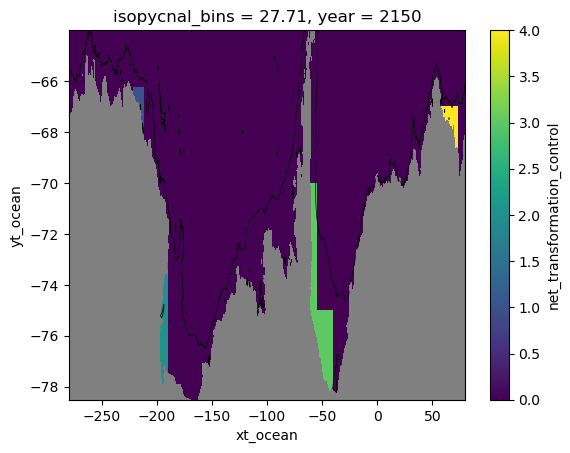

In [18]:
# set up empty masks:
Ross_mask = net_transformation_control[0,0,...]*0+1
Ross_mask = Ross_mask.fillna(1)

Adelie_mask = Ross_mask.copy()
Weddell_mask = Ross_mask.copy()
Prydz_mask = Ross_mask.copy()

yt_ocean = Ross_mask.yt_ocean
xt_ocean = Ross_mask.xt_ocean

# set regions:
Ross_mask = Ross_mask.where(yt_ocean<-72).where(yt_ocean>-79).where(xt_ocean>161.5-360).where(xt_ocean<170-360)

Prydz_mask = Prydz_mask.where(yt_ocean<-67).where(yt_ocean>-69).where(xt_ocean>58).where(xt_ocean<73)

Adelie_mask = Adelie_mask.where(yt_ocean<-66.2).where(yt_ocean>-69).where(xt_ocean>138-360).where(xt_ocean<148-360)

# two area to include for this one:
Weddell_maskW = Weddell_mask.where(yt_ocean<-70).where(yt_ocean>-79).where(xt_ocean>297-360).where(xt_ocean<305-360)
Weddell_maskE = Weddell_mask.where(yt_ocean<-75).where(yt_ocean>-79).where(xt_ocean>305-360).where(xt_ocean<320-360)
Weddell_mask = Weddell_maskE.fillna(0) + Weddell_maskW.fillna(0)
Weddell_mask = Weddell_mask.where(Weddell_mask == 1)

#Weddell_mask.plot()
#plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000],linewidths=0.5,colors='k')
#plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')

### note region order:
# regions = ['Adelie','Ross','Weddell','Prydz']

# combine all masks:
combined_mask = Adelie_mask.fillna(0) + Ross_mask.fillna(0)*2 + Weddell_mask.fillna(0)*3 + Prydz_mask.fillna(0)*4

combined_mask.plot()
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000],linewidths=0.5,colors='k')
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')

array([27.83, 28.03, 27.81, 27.79])

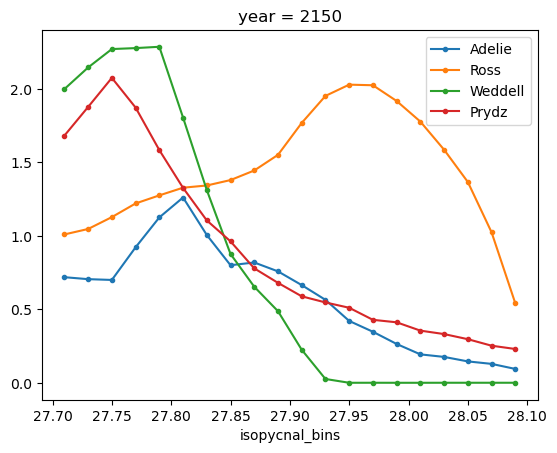

In [19]:
## Find density thresholds to use for each region using a 10 year average of the control:

time_slice = slice(2150,2159)
control_transformation_mean = net_transformation_control.sel(year=time_slice).mean('year')

area_t = cc.querying.getvar(control, 'area_t', master_session, n=1)

regions = ['Adelie','Ross','Weddell','Prydz']
density_threshold = np.zeros(4)

# use density where SWMT is 70% of peak value:
percent_max_SWMT = 0.7

for DSW_region_count in range(4):
    region = regions[DSW_region_count]
    area_mask = area_t.where(combined_mask == DSW_region_count + 1)
    swmt_sum_region = (control_transformation_mean*area_mask).sum(['xt_ocean', 'yt_ocean'])/1e6
    swmt_sum_region.plot(marker='.',label=region)
    # find max value:
    swmt_max = swmt_sum_region.max().values
    # find density where swmt = 0.7*swmt_max:
    density_threshold[DSW_region_count] = swmt_sum_region.where(swmt_sum_region >= swmt_max*percent_max_SWMT,drop=True)[-1].isopycnal_bins.values
    
plt.legend()
    
# TO DO: update SWMT calculation to narrow in on these densities with finer density bins:
density_threshold

Note the Ross SWMT is really dense here, I think that's because it's a very small region right in the western side of the Ross Sea.

### Time average plots:

In [24]:
# average over the 5 years: 
time_slice = slice(2155,2159)

area_t = cc.querying.getvar(control, 'area_t', master_session, n=1)

def plot_time_avg_SWMT(DSW_region_count):
    # select area just for this DSW region:
    
    region = regions[DSW_region_count]
    area_mask = area_t.where(combined_mask == DSW_region_count + 1)
        
    swmt_sum_control = ((net_transformation_control.sel(year=time_slice).mean('year'))* area_mask).sum(['xt_ocean', 'yt_ocean'])/1e6
    swmt_sum_up = ((net_transformation_up.sel(year=time_slice).mean('year'))* area_mask).sum(['xt_ocean', 'yt_ocean'])/1e6
    swmt_sum_down = ((net_transformation_down.sel(year=time_slice).mean('year'))* area_mask).sum(['xt_ocean', 'yt_ocean'])/1e6
    swmt_sum_up_noDSW = ((net_transformation_up_noDSW.sel(year=time_slice).mean('year'))* area_mask).sum(['xt_ocean', 'yt_ocean'])/1e6
    #swmt_sum_up_zonal = ((net_transformation_zonal.sel(year=time_slice).mean('year'))* area_mask).sum(['xt_ocean', 'yt_ocean'])/1e6
    #swmt_sum_up_meridional = ((net_transformation_meridional.sel(year=time_slice).mean('year'))* area_mask).sum(['xt_ocean', 'yt_ocean'])/1e6
    
    plt.plot(swmt_sum_control,swmt_sum_control.isopycnal_bins, 'k',linewidth=1,label='Control')
    plt.plot(swmt_sum_up,swmt_sum_up.isopycnal_bins,label='Up')
    plt.plot(swmt_sum_down,swmt_sum_down.isopycnal_bins,label='Down')
    plt.plot(swmt_sum_up_noDSW,swmt_sum_up_noDSW.isopycnal_bins,label='Up noDSW')
    #plt.plot(swmt_sum_up_zonal,swmt_sum_up_zonal.isopycnal_bins, '.',label='Up zonal')
    #plt.plot(swmt_sum_up_meridional,swmt_sum_up_meridional.isopycnal_bins,'.', label='Up meridional')
    plt.ylim((28.1, 27.7))
    plt.ylabel(r'$\sigma_{0}$ (kg m$^{-3}$)', fontsize = fontsize)
    plt.xlabel('Surface water mass transformation (Sv)', fontsize=fontsize)
    plt.legend(loc=2, fontsize = fontsize);
    plt.tick_params(labelsize=fontsize)
    plt.title(region+' SWMT, years 2155-2159', fontsize=fontsize);


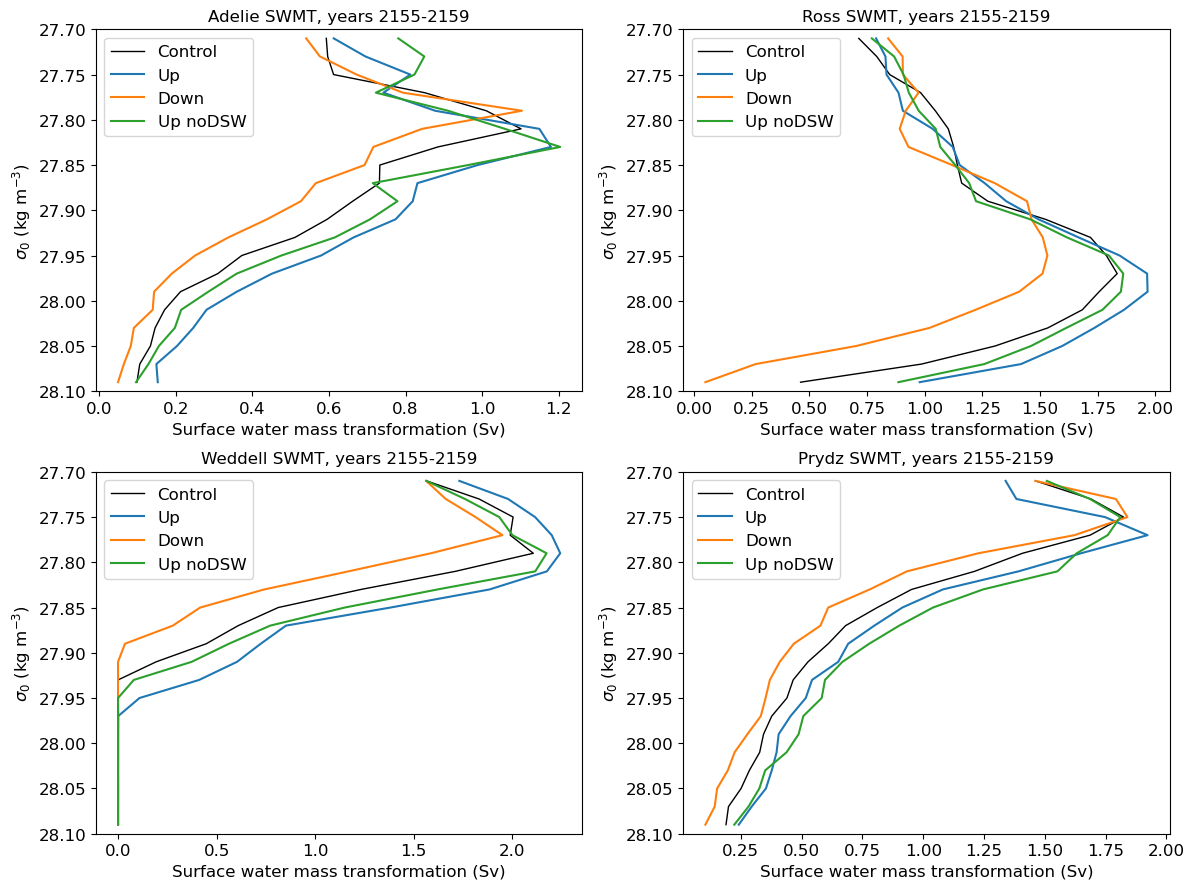

In [25]:
fontsize = 12
fig = plt.figure(num=1, figsize = (12, 9))

plt.subplot(2,2,1)
plot_time_avg_SWMT(0)

plt.subplot(2,2,2)
plot_time_avg_SWMT(1)

plt.subplot(2,2,3)
plot_time_avg_SWMT(2)

plt.subplot(2,2,4)
plot_time_avg_SWMT(3)

plt.tight_layout()

### Plot timeseries of SWMT:

In [30]:
area_t = cc.querying.getvar(control, 'area_t', master_session, n=1)

def plot_time_series_SWMT(DSW_region_count):

    region = regions[DSW_region_count]
    area_mask = area_t.where(combined_mask == DSW_region_count + 1)
    density = density_threshold[DSW_region_count]
    
    # Extract single DSW region, multiply by area and sum over lat/lon, convert to Sv:
    swmt_control_timeseries = (net_transformation_control* area_mask).sum(['xt_ocean', 'yt_ocean'])/1e6
    swmt_up_timeseries = (net_transformation_up* area_mask).sum(['xt_ocean', 'yt_ocean'])/1e6
    swmt_down_timeseries = (net_transformation_down* area_mask).sum(['xt_ocean', 'yt_ocean'])/1e6
    swmt_up_noDSW_timeseries = (net_transformation_up_noDSW* area_mask).sum(['xt_ocean', 'yt_ocean'])/1e6  
    #swmt_up_zonal_timeseries = (net_transformation_zonal* area_mask).sum(['xt_ocean', 'yt_ocean'])/1e6
    #swmt_up_meridional_timeseries = (net_transformation_meridional* area_mask).sum(['xt_ocean', 'yt_ocean'])/1e6
                              
    plt.plot(swmt_control_timeseries.year,swmt_control_timeseries.sel(isopycnal_bins=density,method='nearest').squeeze(),
             'k',linewidth=1,label='Control')
    plt.plot(swmt_up_timeseries.year,swmt_up_timeseries.sel(isopycnal_bins=density,method='nearest').squeeze(),label='Up')
    plt.plot(swmt_down_timeseries.year,swmt_down_timeseries.sel(isopycnal_bins=density,method='nearest').squeeze(),label='Down')
    plt.plot(swmt_up_noDSW_timeseries.year,swmt_up_noDSW_timeseries.sel(isopycnal_bins=density,method='nearest').squeeze(),label='Up noDSW')
    #plt.plot(swmt_up_zonal_timeseries.year,swmt_up_zonal_timeseries.sel(isopycnal_bins=density,method='nearest').squeeze(),label='Up zonal')
    #plt.plot(swmt_up_meridional_timeseries.year,swmt_up_meridional_timeseries.sel(isopycnal_bins=density,method='nearest').squeeze(),label='Up meridional')
    plt.xlabel(r'Year', fontsize = fontsize)
    plt.ylabel('Surface water mass transformation (Sv)', fontsize=fontsize)
    plt.legend(loc=4, ncol=1, fontsize = fontsize);
    plt.tick_params(labelsize=fontsize)
    plt.title(region+' SWMT at $\sigma_0$='+str(density), fontsize=fontsize);


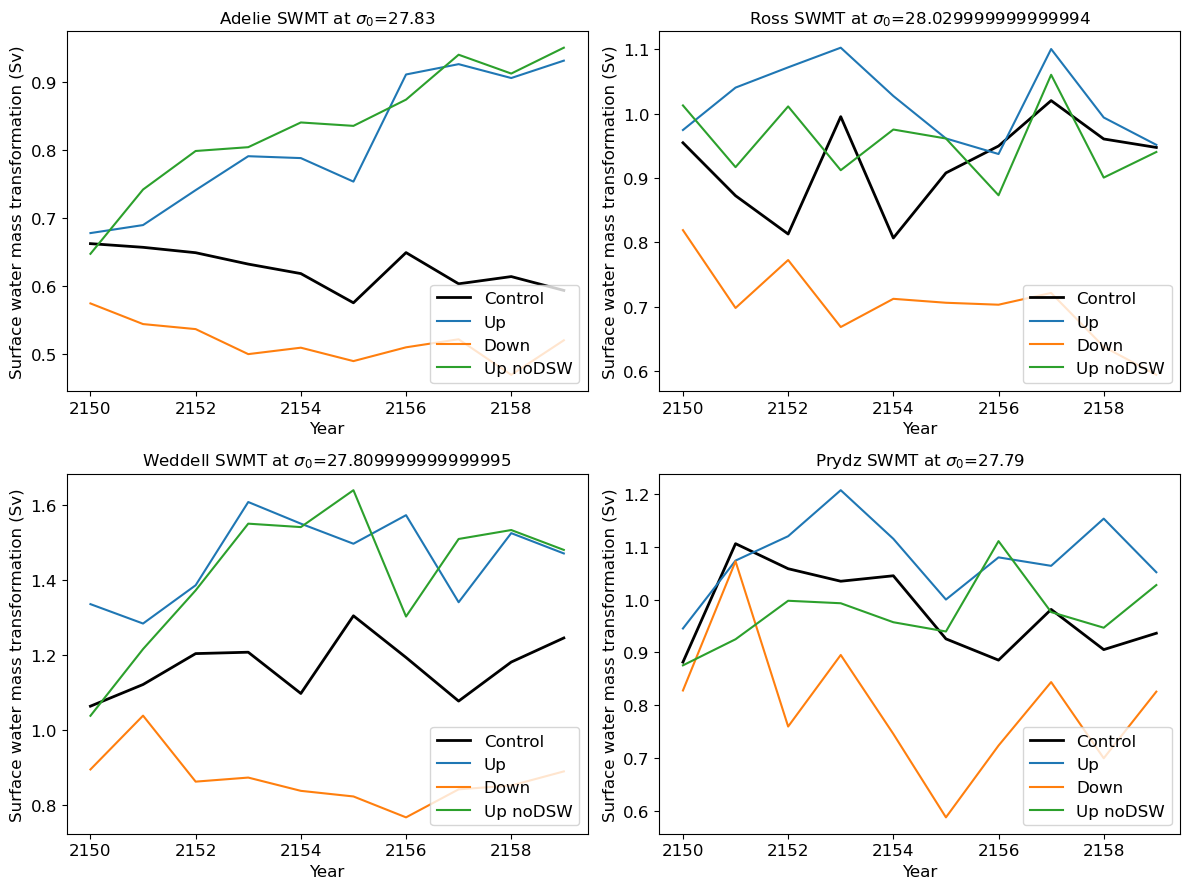

In [31]:
fontsize = 12
fig = plt.figure(num=1, figsize = (10, 9))

plt.subplot(2,2,1)
plot_time_series_SWMT(0)

plt.subplot(2,2,2)
plot_time_series_SWMT(1)

plt.subplot(2,2,3)
plot_time_series_SWMT(2)

plt.subplot(2,2,4)
plot_time_series_SWMT(3)

plt.tight_layout()

## Plot bar chart:

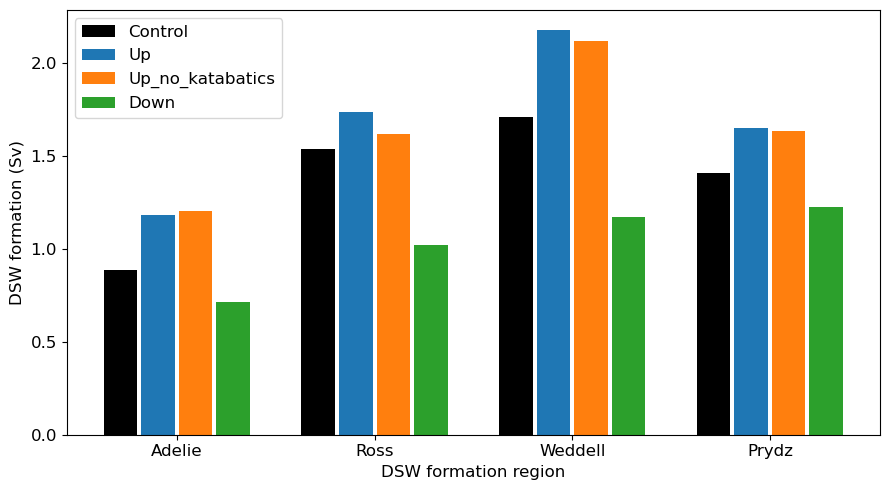

In [54]:
time_slice = slice(2155,2159)

control_values = np.zeros(4)
up_values = np.zeros(4)
down_values = np.zeros(4)
up_noDSW_values = np.zeros(4)

for DSW_region_count in range(4):

    region = regions[DSW_region_count]
    area_mask = area_t.where(combined_mask == DSW_region_count + 1)
    density = density_threshold[DSW_region_count]
    
    # Extract single DSW region, multiply by area and sum over lat/lon, convert to Sv:
    control_values[DSW_region_count] = (net_transformation_control.sel(isopycnal_bins=density,method='nearest').sel(year=time_slice).mean('year')* area_mask).sum(['xt_ocean', 'yt_ocean'])/1e6
    up_values[DSW_region_count] = (net_transformation_up.sel(isopycnal_bins=density,method='nearest').sel(year=time_slice).mean('year')* area_mask).sum(['xt_ocean', 'yt_ocean'])/1e6
    down_values[DSW_region_count] = (net_transformation_down.sel(isopycnal_bins=density,method='nearest').sel(year=time_slice).mean('year')* area_mask).sum(['xt_ocean', 'yt_ocean'])/1e6
    up_noDSW_values[DSW_region_count] = (net_transformation_up_noDSW.sel(isopycnal_bins=density,method='nearest').sel(year=time_slice).mean('year')* area_mask).sum(['xt_ocean', 'yt_ocean'])/1e6  

x = np.arange(len(regions))  # the label locations
width = 0.17  # the width of the bars

fig, ax = plt.subplots(figsize=(9,5))
rects1 = ax.bar(x - 3/2*width-.03, control_values, width,color='k',label='Control')
# example of error bars if we want these:
#rects1 = ax.bar(x - 3/2*width-.03, control_values, width,yerr=.2, ecolor='gray',capsize=5,color='k',label='Control')
rects2 = ax.bar(x - width/2-.01, up_values, width, label='Up')
rects3 = ax.bar(x + width/2+.01, up_noDSW_values, width, label='Up_no_katabatics')
rects4 = ax.bar(x + 3/2*width+.03, down_values, width, label='Down')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('DSW formation (Sv)',fontsize=fontsize)
ax.set_xlabel('DSW formation region',fontsize=fontsize)
#ax.set_title('Heat transport components',fontsize=fontsize)
ax.set_xticks(x)
ax.set_xticklabels(regions)
ax.legend(fontsize=fontsize,loc=2)
plt.tick_params(labelsize=fontsize)
#plt.plot([-1,4],[0,0],'k')
#plt.xlim(-.5,3.5)

fig.tight_layout()

figure_path = figdir+'Fig4_SWMT_bar_chart.pdf'
fig.savefig(figure_path, dpi=120,bbox_inches='tight', pad_inches=0.1)